# Gradient Boosting

c:\Users\jadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Processing for Target: Total_Exp ---
Data loaded successfully. Training data shape: (7689, 34)
Training XGBoost Regressor model...


c:\Users\jadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\jadit\AppData\Local\Temp\ipykernel_17388\455633295.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(median_val, inplace=True)


Model training complete.
Evaluating model performance...
  R-squared (R²): 0.9998
  Mean Absolute Error (MAE): 54.15
  Root Mean Squared Error (RMSE): 127.52
Generating SHAP feature importance plot...


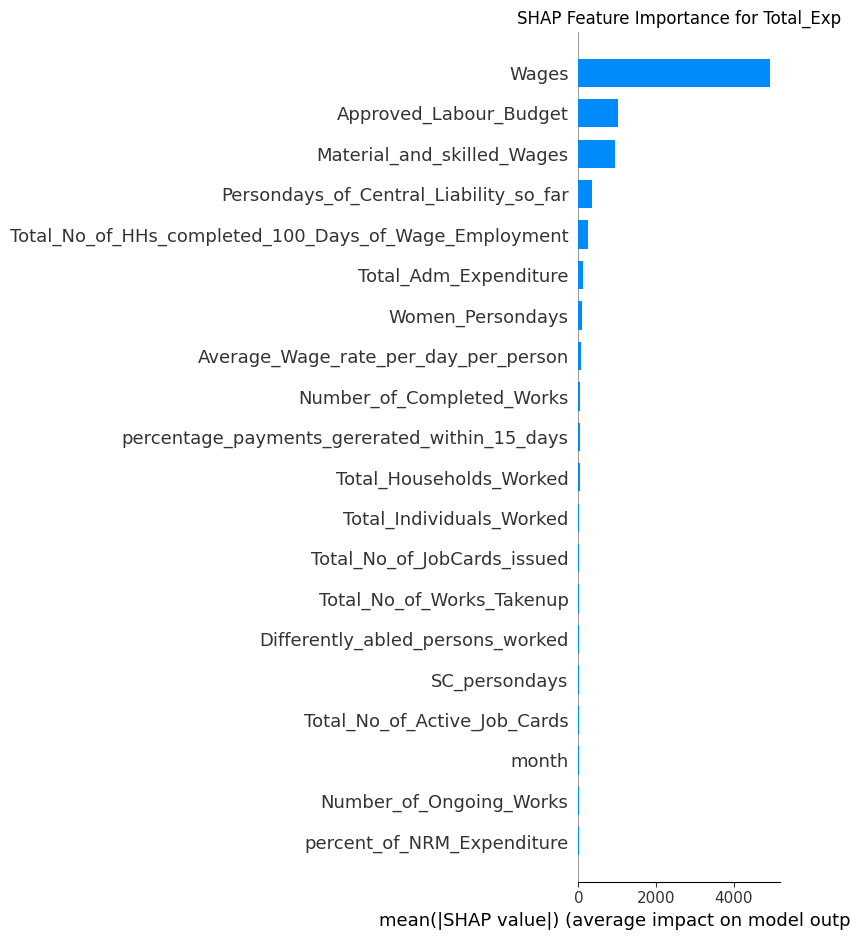

SHAP plot generated. The plot shows the average impact of each feature on the model's prediction.

--- Processing for Target: Average_days_of_employment_provided_per_Household ---
Data loaded successfully. Training data shape: (7689, 34)
Training XGBoost Regressor model...


c:\Users\jadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\jadit\AppData\Local\Temp\ipykernel_17388\455633295.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(median_val, inplace=True)


Model training complete.
Evaluating model performance...
  R-squared (R²): 0.9987
  Mean Absolute Error (MAE): 0.29
  Root Mean Squared Error (RMSE): 0.45
Generating SHAP feature importance plot...


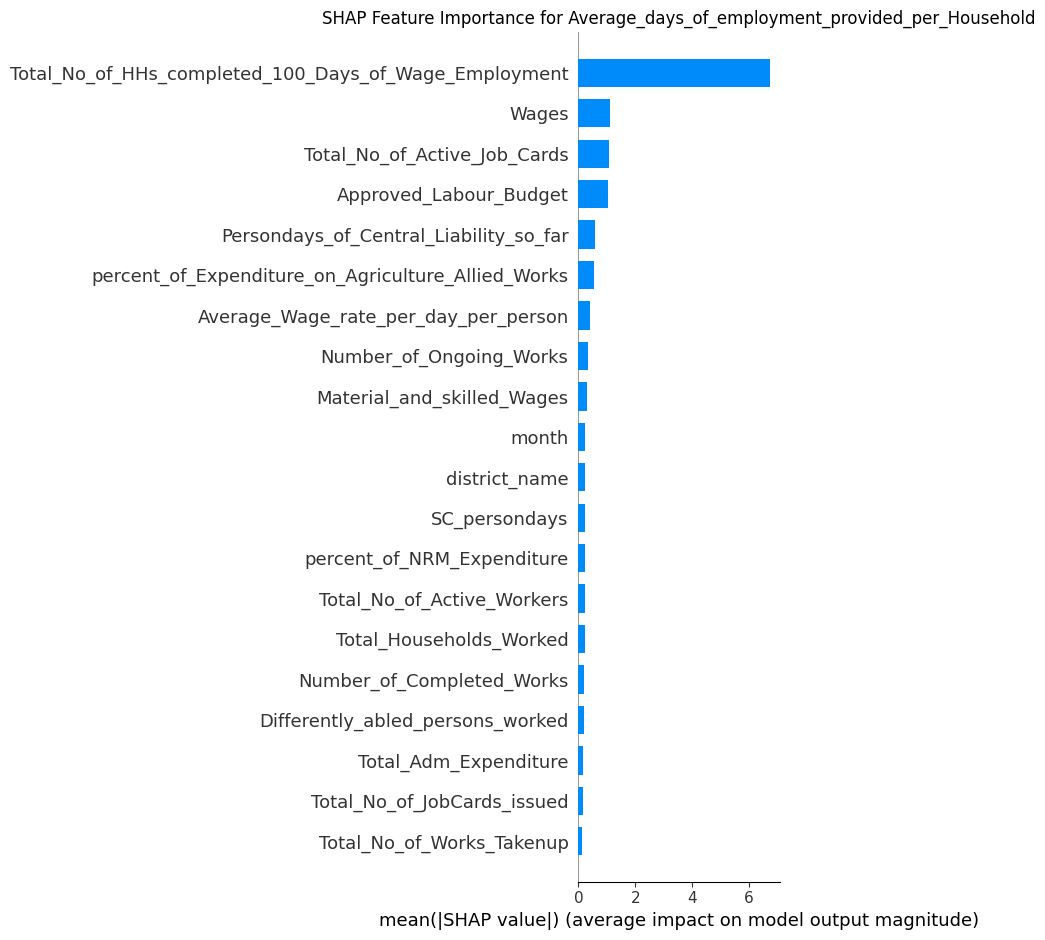

SHAP plot generated. The plot shows the average impact of each feature on the model's prediction.

✅ Task 1: Gradient Boosting implementation complete.


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder

# --- Configuration ---
FILE_PATH = "..\\data\\\combined.csv"  # Assumes your data is in this file
TARGET_VARIABLES = [
    'Total_Exp', 
    'Average_days_of_employment_provided_per_Household'
]
# Note: 'efficiency flags' would require a separate classification model.
# We are focusing on the two specified regression targets.

# --- 1. Data Loading and Preparation Module ---
def load_and_prepare_data(filepath, target_col):
    """
    Loads data, identifies feature types, and performs essential preprocessing.
    
    Args:
        filepath (str): Path to the dataset CSV file.
        target_col (str): The name of the target variable column.
        
    Returns:
        tuple: A tuple containing X_train, X_test, y_train, y_test.
               Returns (None, None, None, None) if data loading fails.
    """
    print(f"\n--- Processing for Target: {target_col} ---")
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        print("Please ensure the dataset is in the same directory or provide the correct path.")
        return None, None, None, None

    # Drop rows where target is NaN, as we can't train/evaluate on them
    df.dropna(subset=[target_col], inplace=True)
    
    # Define features (X) and target (y)
    y = df[target_col]
    X = df.drop(columns=TARGET_VARIABLES, axis=1) # Drop all potential targets

    # Identify categorical and numerical features
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    
    # Handle categorical features using simple label encoding for tree-based models
    # XGBoost can handle integers directly.
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str)) # Convert to string to handle mixed types
        
    # Impute NaNs in feature data with the median (a simple, robust strategy)
    for col in X.columns:
        if X[col].isnull().any():
            median_val = X[col].median()
            X[col].fillna(median_val, inplace=True)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"Data loaded successfully. Training data shape: {X_train.shape}")
    return X_train, X_test, y_train, y_test

# --- 2. Model Training Module ---
def train_xgboost_model(X_train, y_train):
    """
    Initializes and trains an XGBoost Regressor model.
    
    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        
    Returns:
        xgb.XGBRegressor: The trained XGBoost model.
    """
    print("Training XGBoost Regressor model...")
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,          # Number of trees
        learning_rate=0.05,         # Step size shrinkage
        max_depth=5,                # Max depth of a tree
        subsample=0.8,              # Subsample ratio of the training instance
        colsample_bytree=0.8,       # Subsample ratio of columns when constructing each tree
        random_state=42,
        n_jobs=-1,                  # Use all available CPU cores
        early_stopping_rounds=50    # Stop if validation score doesn't improve
    )
    
    # Using a simple eval set for early stopping
    eval_set = [(X_train, y_train)] # In a real project, use a separate validation set
    
    model.fit(
        X_train, y_train, 
        eval_set=eval_set,
        verbose=False # Set to True to see training progress
    )
    print("Model training complete.")
    return model

# --- 3. Model Evaluation Module ---
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model's performance on the test set.
    
    Args:
        model (xgb.XGBRegressor): The trained model.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
    """
    print("Evaluating model performance...")
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:,.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:,.2f}")

# --- 4. Model Interpretation Module (SHAP) ---
def interpret_model_with_shap(model, X_train, model_name=""):
    """
    Uses SHAP to explain the model's predictions and plots feature importance.
    
    Args:
        model (xgb.XGBRegressor): The trained model.
        X_train (pd.DataFrame): Training data used for SHAP explainer.
        model_name (str): A name for the plot title.
    """
    print("Generating SHAP feature importance plot...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # Generate and display the summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance for {model_name}')
    plt.tight_layout()
    plt.show()
    print("SHAP plot generated. The plot shows the average impact of each feature on the model's prediction.")

# --- Main Execution ---
if __name__ == "__main__":
    for target in TARGET_VARIABLES:
        # Step 1: Load and prepare data for the current target
        X_train, X_test, y_train, y_test = load_and_prepare_data(FILE_PATH, target)
        
        if X_train is not None:
            # Step 2: Train the model
            xgb_model = train_xgboost_model(X_train, y_train)
            
            # Step 3: Evaluate the model
            evaluate_model(xgb_model, X_test, y_test)
            
            # Step 4: Interpret the model with SHAP
            interpret_model_with_shap(xgb_model, X_train, model_name=target)

    print("\n✅ Task 1: Gradient Boosting implementation complete.")

# DecisionTreeRegressor and RandomForestRegressor

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# --- 1. Load Your Data ---
# Replace 'your_dataset.csv' with the actual path to your data file.
print("Step 1: Loading data...")

try:
    # >>> IMPORTANT <<<
    # >>> RENAME 'your_dataset.csv' TO THE NAME OF YOUR DATA FILE <<<
    df = pd.read_csv('..\\data\\combined.csv')
    print("Dataset loaded successfully with {} rows and {} columns.".format(df.shape[0], df.shape[1]))
    # print("Sample data:")
    # print(df.head())

    # --- Simple Data Cleaning ---
    # It's good practice to handle missing values.
    # We'll drop rows where our target or key features are missing to ensure model accuracy.
    required_columns = [
        'Total_Exp', 'Total_Adm_Expenditure', 'Material_and_skilled_Wages',
        'Approved_Labour_Budget', 'Wages', 'Total_No_of_Active_Workers', 'state_name'
    ]
    df.dropna(subset=required_columns, inplace=True)
    # print(f"\nAfter dropping rows with missing values in key columns, {len(df)} rows remain.")

except FileNotFoundError:
    print("Error: 'your_dataset.csv' not found.")
    print("Please update the file path and ensure the dataset is in the same directory as the script.")
    # Exit the script if the file isn't found, to prevent further errors.
    exit()
print("-" * 50)


# --- 2. Data Preprocessing ---
print("\nStep 2: Preprocessing data...")

# Define features (X) and target (y)
# The business question is: "Which features most impact spending?"
# So, our target variable 'y' will be 'Total_Exp'.
target = 'Total_Exp'

# We select features that are likely to be cost drivers.
# We include both numerical and categorical features.
features = [
    'Total_Adm_Expenditure',
    'Material_and_skilled_Wages',
    'Approved_Labour_Budget',
    'Wages',
    'Total_No_of_Active_Workers',
    'state_name' # This is a categorical feature we need to encode
]

X = df[features]
y = df[target]

# One-Hot Encode categorical features
# This converts categories like 'State A', 'State B' into numerical format (0s and 1s)
# so the model can process them.
X = pd.get_dummies(X, columns=['state_name'], drop_first=True)

# print("Features after one-hot encoding:")
# print(X.head())
print("-" * 50)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData split into training ({len(X_train)} rows) and testing ({len(X_test)} rows) sets.")
print("-" * 50)


# --- 3. Model Training and Feature Importance ---

def train_and_evaluate(model, model_name):
    """A helper function to train a model, evaluate it, and print feature importances."""
    print(f"\nTraining {model_name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    print(f"{model_name} - Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Get feature importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(f"\nFeature Importances from {model_name} (Top cost drivers):")
    print(feature_importance_df)
    print("-" * 50)


# --- Model 1: CART (Decision Tree Regressor) ---
# Note: CART for regression is simply DecisionTreeRegressor.
dt_regressor = DecisionTreeRegressor(random_state=42)
train_and_evaluate(dt_regressor, "CART Decision Tree Regressor")


# --- Model 2: Random Forest Regressor ---
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
train_and_evaluate(rf_regressor, "Random Forest Regressor")

print("\nAnalysis Complete.")
print("The tables above show which features had the most impact on 'Total_Exp'.")
print("A higher 'Importance' value indicates a stronger driver of spending.")



Step 1: Loading data...
Dataset loaded successfully with 9612 rows and 36 columns.
--------------------------------------------------

Step 2: Preprocessing data...
--------------------------------------------------

Data split into training (7689 rows) and testing (1923 rows) sets.
--------------------------------------------------

Training CART Decision Tree Regressor...
CART Decision Tree Regressor - Root Mean Squared Error (RMSE): 216.61

Feature Importances from CART Decision Tree Regressor (Top cost drivers):
                      Feature  Importance
3                       Wages    0.842739
2      Approved_Labour_Budget    0.125693
1  Material_and_skilled_Wages    0.025422
0       Total_Adm_Expenditure    0.005382
4  Total_No_of_Active_Workers    0.000764
--------------------------------------------------

Training Random Forest Regressor...
Random Forest Regressor - Root Mean Squared Error (RMSE): 117.56

Feature Importances from Random Forest Regressor (Top cost drivers):
   

# Supervised - Classification

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
# Note: You may need to install XGBoost: pip install xgboost
from xgboost import XGBClassifier

# --- 1. Load Your Data ---
# Replace 'your_dataset.csv' with the actual path to your data file.
print("Step 1: Loading data...")

try:
    # >>> IMPORTANT <<<
    # >>> RENAME 'your_dataset.csv' TO THE NAME OF YOUR DATA FILE <<<
    df = pd.read_csv('..\\data\\combined.csv')
    print("Dataset loaded successfully with {} rows and {} columns.".format(df.shape[0], df.shape[1]))
    print("Sample data:")
    print(df.head())

    # --- Simple Data Cleaning ---
    # We'll drop rows where our target or key features are missing to ensure model accuracy.
    required_columns = [
        'Total_Exp', 'Approved_Labour_Budget', 'state_name', 'district_name'
    ]
    df.dropna(subset=required_columns, inplace=True)
    print(f"\nAfter dropping rows with missing values in key columns, {len(df)} rows remain.")

except FileNotFoundError:
    print("Error: 'your_dataset.csv' not found.")
    print("Please update the file path and ensure the dataset is in the same directory as the script.")
    # Exit the script if the file isn't found, to prevent further errors.
    exit()
print("-" * 50)


# --- 2. Feature Engineering: Create the Target Variable ---
print("\nStep 2: Creating the target variable for classification...")
# The business question is "Budget overrun?" which is when Actual > Approved.
# We create a binary target where 1 means an overrun occurred, and 0 means it did not.
df['budget_overrun'] = (df['Total_Exp'] > df['Approved_Labour_Budget']).astype(int)

print("Target variable 'budget_overrun' created.")
print("Counts of budget overrun (1) vs. no overrun (0):")
print(df['budget_overrun'].value_counts())
print("-" * 50)


# --- 3. Data Preprocessing ---
print("\nStep 3: Preprocessing data...")

# Define features (X) and target (y)
target = 'budget_overrun'

# We select the features that might influence a budget overrun.
# NOTE: We DO NOT include 'Total_Exp' as a feature. The target 'budget_overrun' is
# directly calculated from it (Total_Exp > Approved_Labour_Budget). Including it
# would cause data leakage, where the model gets the answer directly,
# providing no real predictive insight.
features = [
    'Approved_Labour_Budget',
    'state_name',
    'district_name'
]

X = df[features]
y = df[target]

# One-Hot Encode categorical features
# This converts categories into a numerical format (0s and 1s)
# so the models can process them.
X = pd.get_dummies(X, columns=['state_name', 'district_name'], drop_first=True)

# Sanitize feature names for XGBoost
# XGBoost can have issues with column names containing special characters.
# We will clean them to ensure compatibility.
import re
X.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X.columns]


print("Features after one-hot encoding (showing first 5 rows and a few columns):")
print(X.head())
print("-" * 50)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData split into training ({len(X_train)} rows) and testing ({len(X_test)} rows) sets.")
print("-" * 50)


# --- 4. Model Training and Feature Importance ---

def train_and_evaluate(model, model_name):
    """A helper function to train a classification model, evaluate it, and print feature importances."""
    print(f"\n--- Training {model_name} ---")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy:.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print(f"\nFeature Importances from {model_name} (Top drivers of budget overrun):")
        # Display top 10 most important features
        print(feature_importance_df.head(10))
    print("-" * 50)


# --- Model 1: Decision Tree Classifier ---
dt_classifier = DecisionTreeClassifier(random_state=42)
train_and_evaluate(dt_classifier, "Decision Tree Classifier")


# --- Model 2: XGBoost Classifier ---
xgb_classifier = XGBClassifier(random_state=42, eval_metric='logloss')
train_and_evaluate(xgb_classifier, "XGBoost Classifier")

print("\nAnalysis Complete.")
print("The tables above show which features are the most powerful predictors of a budget overrun.")
print("This helps answer 'What leads to budget overruns?'.")




Step 1: Loading data...
Dataset loaded successfully with 9612 rows and 36 columns.
Sample data:
    fin_year  month  state_code   state_name  district_code district_name  \
0  2023-2024  March          18  MAHARASHTRA           1804     RATNAGIRI   
1  2023-2024  March          18  MAHARASHTRA           1807         DHULE   
2  2023-2024  March          18  MAHARASHTRA           1809    AHMEDNAGAR   
3  2023-2024  March          18  MAHARASHTRA           1817      PARBHANI   
4  2023-2024  March          18  MAHARASHTRA           1820     Dharashiv   

   Approved_Labour_Budget  Average_Wage_rate_per_day_per_person  \
0                  534483                            298.402239   
1                 1329507                            311.223189   
2                 2247080                            321.932569   
3                 4450591                            322.118343   
4                 1605784                            303.088948   

   Average_days_of_employment_provided

XGBoostError: [00:34:57] C:\actions-runner\_work\xgboost\xgboost\src\objective\./regression_loss.h:68: Check failed: base_score > 0.0f && base_score < 1.0f: base_score must be in (0,1) for logistic loss, got: 0